In [231]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [157]:
# Load the uploaded datasets
root_path = os.getcwd()
train_dataset = pd.read_excel(root_path + "/data/Tongji/time_series_375_prerpocess_en.xlsx")
test_dataset = pd.read_excel(root_path + "/data/Tongji/time_series_test_110_preprocess_en.xlsx")

In [84]:
def show_data(data):
    print("dataset.shape = ", data.shape)
    columns = data.columns
    for i, col in enumerate(columns):
        print("{}, {},     : {}".format(i, col, data[col][0]))
    print(data.head(5))
show_data(test_dataset)

dataset.shape =  (757, 8)
0, PATIENT_ID,     : 1.0
1, RE_DATE,     : 2020-02-10 11:15:00
2, Lactate dehydrogenase,     : nan
3, Hypersensitive c-reactive protein,     : nan
4, (%)lymphocyte,     : 28.0
5, Admission time,     : 2020-02-09 10:47:24
6, Discharge time,     : 2020-02-21 14:51:12
7, outcome,     : 0
   PATIENT_ID             RE_DATE  Lactate dehydrogenase  \
0         1.0 2020-02-10 11:15:00                    NaN   
1         NaN 2020-02-10 12:07:00                  183.0   
2         NaN 2020-02-13 09:35:00                    NaN   
3         NaN 2020-02-13 10:06:00                  194.0   
4         2.0 2020-02-09 06:56:00                    NaN   

   Hypersensitive c-reactive protein  (%)lymphocyte      Admission time  \
0                                NaN           28.0 2020-02-09 10:47:24   
1                                5.1            NaN 2020-02-09 10:47:24   
2                                NaN           28.6 2020-02-09 10:47:24   
3                          

In [158]:
def generate_clean_train_dataset(df, feature_list):
    df["PATIENT_ID"] = df["PATIENT_ID"].ffill()
    df = df.loc[:, feature_list].copy()
    df["Admission time"] = pd.to_datetime(df["Admission time"])
    df["Discharge time"] = pd.to_datetime(df["Discharge time"])
    df["t"] = (df["Discharge time"] - df["Admission time"]).dt.days
    t_list = df.groupby("PATIENT_ID")["t"].unique().apply(lambda x: x[0]).tolist()
    outcome_list = df.groupby("PATIENT_ID")["outcome"].unique().apply(lambda x: x[0]).tolist()
    y_target = [min(35, t) if outcome == 0 else 70 - min(35, t) for outcome, t in zip(outcome_list, t_list)]
    return df, y_target

# Prepare the train and test sets
test_features_list = test_dataset.columns.tolist()
X_train, y_train = generate_clean_train_dataset(train_dataset, test_features_list)
X_test, y_test = generate_clean_train_dataset(test_dataset, test_features_list)
# Impute missing values
imputer = KNNImputer(n_neighbors=5)
X_train_numeric = X_train.select_dtypes(include=[np.number])    # remain only columns with numerical data types
X_test_numeric = X_test.select_dtypes(include=[np.number])

X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_numeric), columns=X_train_numeric.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test_numeric), columns=X_test_numeric.columns)

show_data(pd.DataFrame(y_test))

dataset.shape =  (110, 1)
0, 0,     : 12
    0
0  12
1  12
2  53
3  20
4  12


In [161]:
# Group by 'PATIENT_ID' to get one row per patient
X_train_final_last = X_train_imputed.groupby("PATIENT_ID").last().reset_index()
X_test_final_last = X_test_imputed.groupby("PATIENT_ID").last().reset_index()
#show_data(X_test_final)

In [162]:
# remove "t" and "outcome", "patientid"
X_train_final = X_train_final_last.drop(columns=["PATIENT_ID","outcome","t"])
X_test_final = X_test_final_last.drop(columns=["PATIENT_ID","outcome","t"])
show_data(X_train_final)

dataset.shape =  (375, 3)
0, Lactate dehydrogenase,     : 232.0
1, Hypersensitive c-reactive protein,     : 19.04
2, (%)lymphocyte,     : 22.720000000000002
   Lactate dehydrogenase  Hypersensitive c-reactive protein  (%)lymphocyte
0                  232.0                              19.04          22.72
1                  405.4                              23.80          14.74
2                  282.0                              35.12          22.90
3                  267.2                              35.12          18.42
4                  257.8                              26.82          23.60


In [163]:
# Convert features and target to PyTorch tensors
X_train_tensor = torch.tensor(X_train_final.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_final.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
print("X_train_tensor.shape = {}, y_train_tensor.shape = {}, X_test_tensor.shape = {}, y_test_tensor.shape = {}".format(X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape))
# DataLoader for training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

X_train_tensor.shape = torch.Size([375, 3]), y_train_tensor.shape = torch.Size([375, 1]), X_test_tensor.shape = torch.Size([110, 3]), y_test_tensor.shape = torch.Size([110, 1])


In [229]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Model initialization
input_size = X_train_tensor.shape[1]
model = MLP(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 200
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    #print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}")

# Calculate MSE and MAE on the test set
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    mse = mean_squared_error(y_test_tensor, predictions)
    mae = mean_absolute_error(y_test_tensor, predictions)
    print(f"Test MSE: {mse:.4f}")
    print(f"Test MAE: {mae:.4f}")

Test MSE: 152.2419
Test MAE: 6.4463


Test MSE: 158.7919
Test MSE: 157.7314
Test MSE: 160.2996
Test MSE: 176.3236
Test MSE: 197.0569


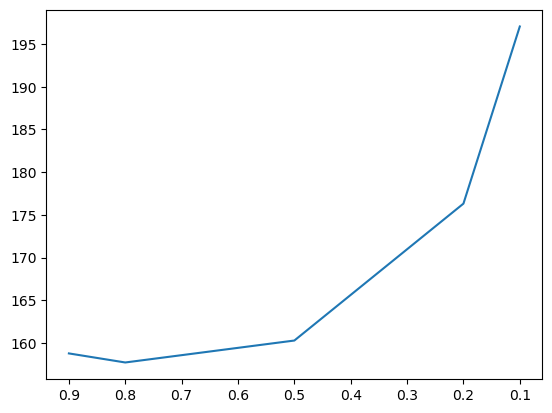

In [153]:
# results 2
# total data
np.random.seed(42)
X_train_final = X_train_final_last.drop(columns=["PATIENT_ID","outcome","t"])
X_test_final = X_test_final_last.drop(columns=["PATIENT_ID","outcome","t"])


def evaluate_different_training_volume(X_train, y_train, X_test, y_test):
    epochs = 200
    batch_size = 32
    pct_list = [0.9, 0.8, 0.5, 0.2, 0.1]

    mse_scores = []

    for i, pct in enumerate(pct_list):
        num_rows = int(pct * len(X_train))
        select_idx = np.random.choice(len(X_train), size=num_rows, replace=False)

        X_train_pct = X_train.sample(frac=pct, replace=False, random_state=42)
        select_idx = X_train_pct.index
        #print(len(select_idx))
        y_train_pct = [y_train[i] for i in select_idx]

        #rest_idx = np.setdiff1d(X_train.index, select_idx)
        #X_test = X_train.loc[rest_idx]
        #y_test = [y_train[i] for i in rest_idx]


        # Convert features and target to PyTorch tensors
        X_train_tensor = torch.tensor(X_train_pct.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_pct, dtype=torch.float32).unsqueeze(1)
        X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

        # DataLoader for training
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Model initialization
        input_size = X_train_tensor.shape[1]
        model = MLP(input_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                epoch_loss = running_loss / len(train_loader.dataset)
        #print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}")

        # Calculate MSE and MAE on the test set
        model.eval()
        with torch.no_grad():
            predictions = model(X_test_tensor)
            mse = mean_squared_error(y_test_tensor, predictions)
            mae = mean_absolute_error(y_test_tensor, predictions)
        print(f"Test MSE: {mse:.4f}")
        #print(f"Test MAE: {mae:.4f}")

        mse_scores.append(mse)

    return pct_list, mse_scores

# Run the evaluation
percentage, mse_scores = evaluate_different_training_volume(X_train_final, y_train, X_test_final, y_test)

plt.plot(percentage, mse_scores)
plt.gca().invert_xaxis()


91
6727


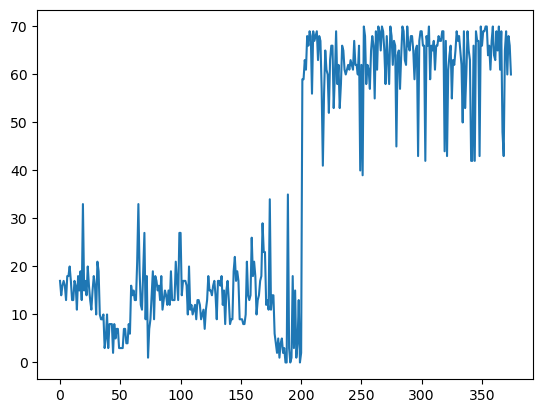

In [247]:
y_tmp = np.array(y_train)
print(y_tmp[y_tmp < 7].sum())
print(y_tmp[y_tmp > 63].sum())
plt.plot(range(len(y_tmp)), y_tmp)

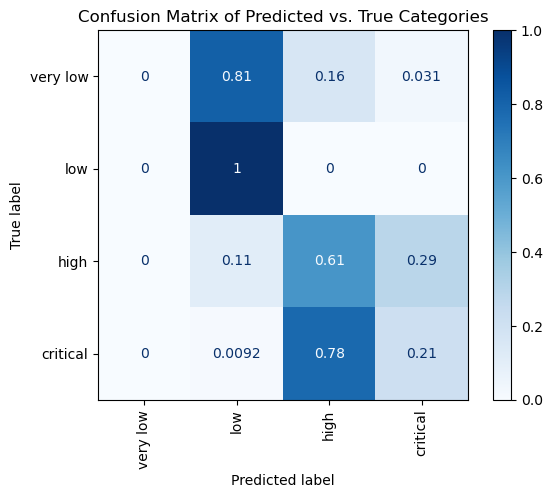

In [249]:
# confusion matrix, result 3
def categorize(y):
    categories = []
    for value in y:
        if value < 7:
            categories.append("very low")
        elif 7 <= value < 35:
            categories.append("low")
        elif 35 <= value < 63:
            categories.append("high")
        else:  # y >= 63
            categories.append("critical")
    return categories

# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(X_train_tensor)
    predictions = predictions.numpy().flatten()  # Convert to numpy array and flatten
    y_train = y_train_tensor.numpy().flatten()  # Convert target to numpy array and flatten

    # Categorize predictions and true targets
    pred_categories = categorize(predictions)
    true_categories = categorize(y_train)

    # Generate confusion matrix
    cm = confusion_matrix(true_categories, pred_categories, labels=["very low", "low", "high", "critical"])
    cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=["very low", "low", "high", "critical"])
    disp.plot(cmap="Blues", xticks_rotation="vertical")
    plt.title("Confusion Matrix of Predicted vs. True Categories")
    plt.show()


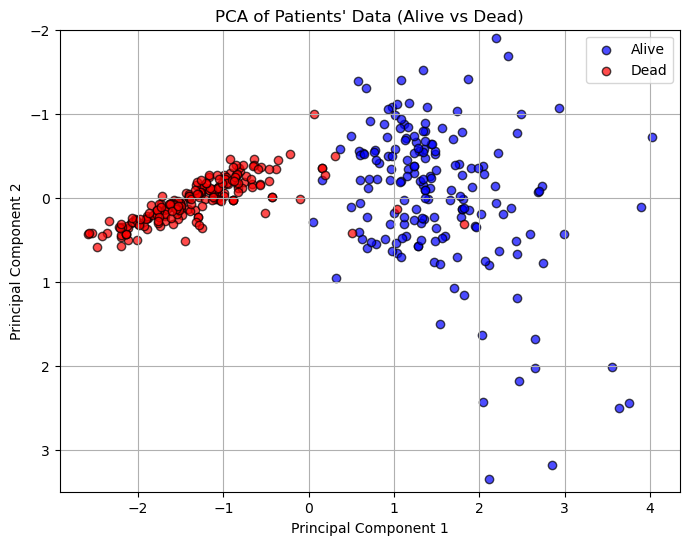

In [169]:
# PCA, result 4
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Group by 'PATIENT_ID' to get one row per patient
X_train_final_last = X_train_imputed.groupby("PATIENT_ID").last().reset_index()
X_test_final_last = X_test_imputed.groupby("PATIENT_ID").last().reset_index()

# remove "t" and "outcome", "patientid"
y_pca = X_train_final_last["outcome"]
X_pca = X_train_final_last.drop(columns=["PATIENT_ID","outcome", "t"])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))

# Plot points: Blue for alive (outcome = 1), Red for dead (outcome = 0)
plt.scatter(X_pca[y_pca == 1, 0], X_pca[y_pca == 1, 1], c='blue', label='Alive', edgecolor='k', alpha=0.7)
plt.scatter(X_pca[y_pca == 0, 0], X_pca[y_pca == 0, 1], c='red', label='Dead', edgecolor='k', alpha=0.7)

# Labels and Title
plt.title("PCA of Patients' Data (Alive vs Dead)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(loc="best")
plt.grid(True)
plt.ylim(3.5, -2)
# Show the plot
plt.show()